In [1]:
import numpy as np
import pandas as pd
from os import listdir
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Sequential
from os.path import isfile, join
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv1D,
    MaxPooling1D,
    Dropout,
    Flatten,
    Dense,
    BatchNormalization,
)

In [2]:
mypath = "/kaggle/input/seismic-data/data/train/moon"
csv_files = [join(mypath, f) for f in listdir(mypath) if isfile(join(mypath, f))]

In [3]:
catalog_df = pd.read_csv(
    "/kaggle/input/seismic-detection-across-the-solar-system/data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv"
)

In [4]:
time_steps = 500  # Set your preferred time window length

In [6]:
# CNN-based model for time-series classification
model = Sequential()

# Add convolutional layers
model.add(
    Conv1D(filters=64, kernel_size=3, activation="relu", input_shape=(time_steps, 2))
)  # 2 is the number of features
model.add(BatchNormalization())  # Helps with convergence
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(filters=32, kernel_size=3, activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

# Flatten and add a dense layer
model.add(Flatten())
model.add(Dense(64, activation="relu"))  # Fully connected layer after convolutions
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))  # Output layer for binary classification

# model = load_model("/kaggle/working/quake_detector_model(Velocity_only)-CNN.h5")
# Compile the model
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"],
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
def proximity_list(length, certain_index):
    proximity = [0] * length  # Initialize list with zeros
    max_distance = max(
        certain_index, length - 1 - certain_index
    )  # Max distance from certain_index to the start/end
    for i in range(length):
        # Calculate distance from the certain index
        distance = abs(i - certain_index)
        # Normalize the value so it peaks at 1 at the certain index and decreases symmetrically
        proximity[i] = 1 - (distance / max_distance)
    return proximity

In [8]:
def process_file_in_batch(csv_file, model, index):
    # Load a single CSV file
    df = pd.read_csv(csv_file)

    df["proximity"] = proximity_list(
        len(df.index), catalog_df["time_rel(sec)"].iloc[index]
    )

    # Include the new features along with time_rel and velocity
    X = df[["proximity", "velocity"]].values
    y = df["mq"].values

    # Reshape X for LSTM (samples, time_steps, features)
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i : i + time_steps])
        y_seq.append(y[i + time_steps - 1])

    # Convert to NumPy arrays for model training
    X_seq, y_seq = np.array(X_seq), np.array(y_seq)

    # Train the model incrementally or append the processed data for batch processing
    model.fit(X_seq, y_seq)
    model.save("quake_detector_model(proximity)-CNN.h5")

In [38]:
# Process files one by one
c = 0
for csv_file in csv_files[0:1]:
    print(c)
    process_file_in_batch(csv_file, model, c)
    c += 1

0
 6806/17873 ━━━━━━━━━━━━━━━━━━━━ 10:12 55ms/step - accuracy: 0.9736 - loss: 0.2455

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



17872/17873 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9814 - loss: 0.2349

I0000 00:00:1728049742.766129     274 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_85', 24 bytes spill stores, 24 bytes spill loads



17873/17873 ━━━━━━━━━━━━━━━━━━━━ 1019s 56ms/step - accuracy: 0.9814 - loss: 0.2349


In [5]:
# Load the trained model
model = load_model("/kaggle/input/seismic-model/quake_detector_model(proximity)-CNN.h5")

I0000 00:00:1728055609.123308      80 service.cc:145] XLA service 0x7e4b34006810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728055609.123370      80 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1728055609.123374      80 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  113/17873 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step 

I0000 00:00:1728055610.548703      80 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17873/17873 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step


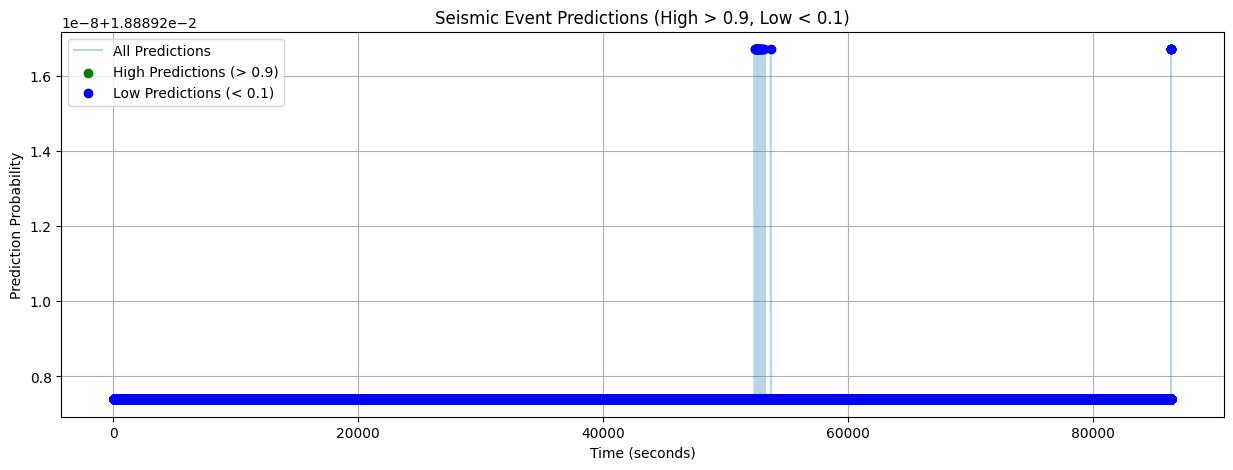

Times of high predictions (probability > 0.9):
Series([], Name: time_rel, dtype: float64)

Times of low predictions (probability < 0.1):
500          75.471698
501          75.622642
502          75.773585
503          75.924528
504          76.075472
              ...     
572406    86400.905660
572407    86401.056604
572408    86401.207547
572409    86401.358491
572410    86401.509434
Name: time_rel, Length: 571911, dtype: float64


In [6]:
# Prepare your test data (assuming you have a test CSV file)
test_file = "/kaggle/input/seismic-data/data/train/moon/12_a_00007.csv"
test_df = pd.read_csv(test_file)

test_df["proximity"] = [0] * len(test_df.index)

# Prepare the test data similar to how you prepared the training data
test_X = test_df[["proximity", "velocity"]].values

# Reshape X for CNN (samples, time_steps, features)
time_steps = 500  # Adjust according to your model's time step requirement
X_test = []
for i in range(len(test_X) - time_steps):
    X_test.append(test_X[i : i + time_steps])

X_test = np.array(X_test)

# Make predictions
predictions = model.predict(X_test)

# Define thresholds for significant predictions
high_threshold = 0.9
low_threshold = 0.1

# Filter predictions greater than 0.9 and less than 0.1
high_predictions = predictions[predictions.flatten() > high_threshold]
high_indices = np.where(predictions.flatten() > high_threshold)[0]

low_predictions = predictions[predictions.flatten() < low_threshold]
low_indices = np.where(predictions.flatten() < low_threshold)[0]

# Plot the results
plt.figure(figsize=(15, 5))

# Plot all predictions
plt.plot(
    test_df["time_rel"][time_steps:], predictions, label="All Predictions", alpha=0.3
)

# Plot high predictions (> 0.9)
plt.scatter(
    test_df["time_rel"][high_indices + time_steps],
    high_predictions,
    color="green",
    label="High Predictions (> 0.9)",
    zorder=5,
)

# Plot low predictions (< 0.1)
plt.scatter(
    test_df["time_rel"][low_indices + time_steps],
    low_predictions,
    color="blue",
    label="Low Predictions (< 0.1)",
    zorder=5,
)

# Plot styling
plt.xlabel("Time (seconds)")
plt.ylabel("Prediction Probability")
plt.title("Seismic Event Predictions (High > 0.9, Low < 0.1)")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

# Print out the times of significant high and low predictions
high_times = test_df["time_rel"][high_indices + time_steps]
low_times = test_df["time_rel"][low_indices + time_steps]

print("Times of high predictions (probability > 0.9):")
print(high_times)

print("\nTimes of low predictions (probability < 0.1):")
print(low_times)